Copyright 2021 The Balloon Learning Environment Authors.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# BLE view flight paths

This notebook allows you to evaluate some of the static agents provided with the Balloon Learning Environment.

Simple run all the cells below in order. You can change some of the parameters as necessary..

In [ ]:
# @title Install necessary libraries
!pip install --upgrade pip
!pip install -U balloon_learning_environment

In [ ]:
# @title Create environments and agents
import gym
from balloon_learning_environment.env import balloon_env
from balloon_learning_environment.env import generative_wind_field
from balloon_learning_environment.utils import run_helpers

wf = generative_wind_field.GenerativeWindField
agents = []
envs = []
for agent in ['station_seeker', 'perciatelli44', 'random_walk']:
  envs.append(gym.make('BalloonLearningEnvironment-v0',
                       wind_field_factory=wf))
  agents.append(run_helpers.create_agent(
      agent,
      envs[-1].action_space.n,
      observation_shape=envs[-1].observation_space.shape))


In [ ]:
# @title Run simulation
seed = 0  # @param {type: 'number'}
num_steps = 1200  # @param {type: 'number'}
frame_skip = 8  # @param {type: 'number'}

times = []
flight_paths = {}
for i, agent in enumerate(agents):
  agent_name = agent.get_name()
  print(f'Running simulation for {agent_name}')
  total_reward = 0.0
  steps_within_radius = 0
  flight_paths[agent_name] = list()
  
  envs[i].seed(seed)
  observation = envs[i].reset()
  action = agent.begin_episode(observation)
  observation = envs[i].reset()
  action = agent.begin_episode(observation)
  
  step_count = 0
  while step_count < num_steps:
    observation, reward, is_done, info = envs[i].step(action)
    action = agent.step(reward, observation)
  
    total_reward += reward
    sim_state = envs[i].get_simulator_state()
    balloon_state = sim_state.balloon_state
    if step_count % frame_skip == 0:
      altitude = sim_state.atmosphere.at_pressure(balloon_state.pressure).height
      charge = balloon_state.battery_soc * 100.0
      flight_paths[agent_name].append((balloon_state.x.km, balloon_state.y.km,
                                       altitude.km, charge))
      if i == 0:
        times.append(balloon_state.date_time)
  
    step_count += 1
  
    if is_done:
      break

  agent.end_episode(reward, is_done)

Running simulation for StationSeekerAgent
Running simulation for Perciatelli44
Running simulation for RandomWalkAgent


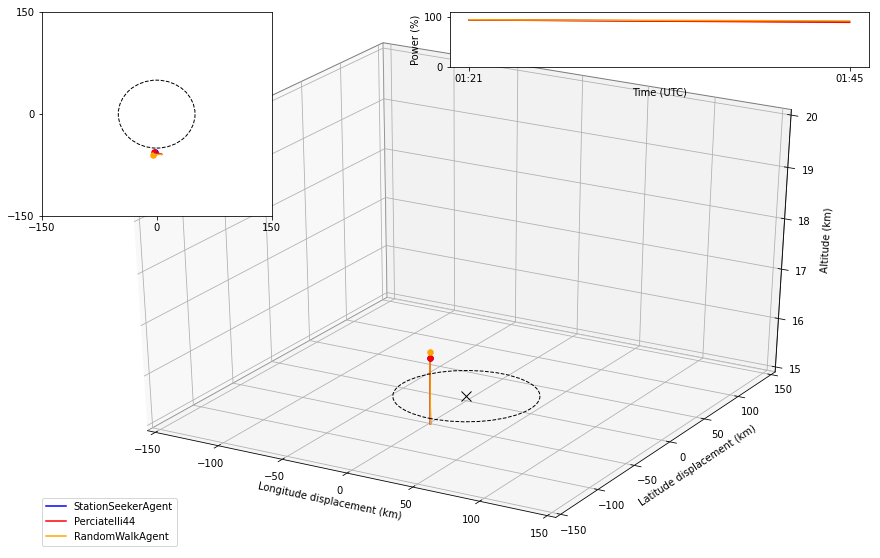

In [55]:
# @title Generate the animation and produce a still.
from matplotlib import animation
from matplotlib import dates as mdates
from matplotlib import gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.mplot3d import art3d
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import rc
rc('animation', html='jshtml')

# Colors for the three agents
colors = ['blue', 'red', 'orange']

# Set up the figure and axes
fig = plt.figure(figsize=(15, 10))
spec = gridspec.GridSpec(ncols=1, nrows=1, height_ratios=[1])
axes = [fig.add_subplot(spec[0], projection='3d')]
axes.append(
    inset_axes(axes[0],
               width='50.0%',
               height='10.0%',
               loc='upper right'))
axes.append(
    inset_axes(axes[0],
               width='27.5%',
               height='37.5%',
               loc='upper left'))

# Set plot limits
xlims = (-150.0, 150.0)
ylims = (-150.0, 150.0)
zlims = (15.0, 20.0)

# This will be a global variable used for the animation
curr_iter = 1

def frame(w):
  global curr_iter
  for ax in axes:
    ax.clear()

  # Draw the main 3d plot
  ax = axes[0]
  ax.set_xlabel('Longitude displacement (km)')
  ax.set_ylabel('Latitude displacement (km)')
  ax.set_zlabel('Altitude (km)')
  ax.set_xlim(xlims)
  ax.set_ylim(ylims)
  ax.set_zlim(zlims)
  ax.set_facecolor('white')
  ax.xaxis.pane.set_edgecolor('black')
  ax.yaxis.pane.set_edgecolor('black')
  ax.grid(True)

  # Draw the target radius
  ax.scatter3D(0.0, 0.0, zlims[0], c='k', lw=1.0, marker='x', s=100)
  circle = plt.Circle((0.0, 0.0), 50.0, edgecolor='k', ls='--', fill=False)
  ax.add_patch(circle)
  art3d.pathpatch_2d_to_3d(circle, z=zlims[0], zdir='z')

  # Draw the flight paths
  for i, agent in enumerate(flight_paths):
    path = flight_paths[agent][:curr_iter]
    ax.plot([f[0] for f in path],
            [f[1] for f in path],
            [f[2] for f in path],
            color=colors[i], label=agent)
    final_pts = [path[-1][i] for i in range(3)]
    ax.scatter(*final_pts, color=colors[i], s=30)
    ax.plot([final_pts[0], final_pts[0]],
            [final_pts[1], final_pts[1]],
            [final_pts[2], zlims[0]],
            color=colors[i])
  
  try:
    ax.text2D(0.05, 0.95, times[curr_iter - 1].strftime('%Y-%m-%d %H:%M:%S'),
              transform=ax.transAxes)
  except:
    pass

  ax.legend(loc='lower left')
  curr_iter += 1

  # Plot power
  ax = axes[1]
  ax.set_ylim([0.0, 110])
  ax.set_xlabel('Time (UTC)')
  ax.set_ylabel('Power (%)')
  try:
    ax.set_xticks([times[0], times[curr_iter - 1]])
  except:
    pass
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
  for i, agent in enumerate(flight_paths):
    path = flight_paths[agent][:curr_iter]
    ax.plot(times[:curr_iter], [f[3] for f in path], color=colors[i])

  # Plot 2D inset
  ax = axes[2]
  ax.set_xlim(xlims)
  ax.set_ylim(ylims)
  ax.set_xticks([xlims[0], 0.0, xlims[1]])
  ax.set_yticks([ylims[0], 0.0, ylims[1]])
  circle = plt.Circle([0.0, 0.0], 50.0, edgecolor='k', ls='--', fill=False)
  ax.add_patch(circle)
  # Draw the flight paths
  for i, agent in enumerate(flight_paths):
    path = flight_paths[agent][:curr_iter]
    ax.plot([f[0] for f in path],
            [f[1] for f in path],
            color=colors[i], label=agent)
    final_pts = [path[-1][i] for i in range(2)]
    ax.scatter(*final_pts, color=colors[i], s=30)
  
  return axes

anim = animation.FuncAnimation(fig, frame,
                               frames=len(flight_paths['Perciatelli44']) - 1,
                               blit=False, repeat=True)

Run one of the two cells below. To avoid large notebooks we are not embedding the generated videos, but you can find them in our [generated directory](https://github.com/google/balloon-learning-environment/tree/master/balloon_learning_environment/generated).

In [56]:
# @title Display the animation!
anim